# Ex01 Almacenamiento y carga de datos (imágenes) en un archivo HDF5


¡Bienvenido a tu primer actividad de programación! Cuando hablamos acerca de Deep Learning, normalmente lo primero que imaginamos es una gran cantidad de datos o una gran cantidad de imágenes (por ejemplo, un par de millones de imágenes de `ImageNet` [1]). Cuando se tienen grandes cantidades de imágenes, no es eficiente cargar cada imagen desde el disco duro por separado, aplicar el preprocesamiento de la imagen y luego pasarla a la red neuronal para entrenar, validar o probar. Es mayor el tiempo requerido para leer múltiples imágenes de un disco duro que tenerlas todas en un archivo y leerlas como un grupo de datos.

Existen diferentes modelos de datos y bibliotecas que podemos utilizar, como `HDF5`[2] y `TFRecord` [3]. En esta actividad trabajaremos con el formato `HDF5`.

$\textbf{Propósito de aprendizaje}$
- Construcción de un `dataset` de imágenes
    - Almacenar imágenes en un archivo `HDF5`
    - Cargar imágenes por lotes desde un archivo `HDF5`.
    
$\textbf{Evaluación de la actividad}$
- Ejercicio 1: 25%
- Ejercicio 2: 25%
- Ejercicio 3: 25%
- Ejercicio 4: 25%

## Uso de librerías

Primero ejecutemos la siguiente celda para importar todas las librerías que necesitaras durante la actividad.

- $\textbf{numpy}$ es una librería para cómputo cinetífico en Python.
- $\textbf{h5py}$ es una librería para interactuar con conjuntos de datos almacenados en el formato H5.
- $\textbf{cv2}$ es una librería de Python (OpenCV) para el procesamiento de imágenes.
- $\textbf{random}$ es una librería que implementa generadores pseduo-aleatorios para varias distribuciones.
- $\textbf{glob}$ es una librería que permite buscar rutas de archivos acorde a un patrón.
- $\textbf{math}$ es una librería que brinda acceso a las funciones matemáticas definidas por el estandar de C.
- $\textbf{matplotlib}$ es una librería para dibujar gráficos en Python.

In [1]:
# Verifique que tenga instalados las siguientes librerías
from random import shuffle
import glob
import numpy as np
import h5py
import cv2
from math import ceil
import matplotlib.pyplot as plt

%matplotlib inline

## Descripción del conjunto de datos

En esta actividad, trabajaremos con un subconjunto de la base de datos Plant Village [4][5]. El subconjunto de datos corresponde a imágenes de hojas de la planta de fresas. En la carpeta de datos de entrenamiento se encuentran archivos JPG con imágenes de hojas enfermas y hojas saludables. Para identificar las imagenes que contiene hojas saludables podemos buscar en el nombre del archivo la subcadena `RS_HL`. Todas las imágenes son a color de 256 x 256 pixeles. Veamos un ejemplo de una hoja saludable y una hoja enferma:

![title](healthy.JPG) ![title](scorch.JPG) 

## 1. Almacenar imágenes en un archivo HDF5

Para la creación del `dataset`de imágenes utilizando el formato HDF5, hemos dividido el proceso en dos etapas:

- $\textbf{Listar las imágenes y etiquetarlas}$. En esta etapa se genera una lista con la ruta de las imágenes que posteriormente serán utilizadas para entrenar, valdidar y probar un modelo. A demás se generan las étiquetas acorde al estado de la hoja en la imagen: hoja enferma = 1, hoja saludable = 0. Adicionalmente, hay que barajear las rutas y dividirlas en tres subconjuntos:
    - Entrenamiento (60%)
    - Validación (20%)
    - Prueba  (20%)

- $\textbf{Crear el archivo HDF5}$. En esta etapa, se crea el archivo HDF5, se define el orden en el que serán almacenados los datos y se construyen los `datasets`.


### 1.1. Listar imágenes y etiquetarlas

Primero necesitamos listar todas las imágenes y etiquetarlas. Asignaremos a cada imagen de una hoja saludable una etiqueta = 0, y a cada imagen de una hoja enferma la etiqueta = 1. 

$\textbf{Ejercicio 1:}$ Implemente la función `build_data_lists` para listar todas las imágenes en `addrs` y en `labels`  asignar las etiquetas adecuadas. Posteriormente, implemente el código requerido para barajear los datos. Adiciomalmente, divida el conjunto de rutas en tres subconjuntos: `train_addrs` (60%), `val_addrs` (20%) y `test_addrs` (20%). Realicemos lo mismo para los subconjuntos de sus respectivas etiquetas: `train_label`, `val_label` y `test_label`.

In [2]:
def build_data_lists(healthy_scorch_path, shuffle_data):
    # leer las rutas de los archivos de la carpeta mix y asignar etiquetas
    addrs = glob.glob(healthy_scorch_path)
    labels = [0 if 'RS_HL' in addr else 1 for addr in addrs]  # 0 = Healthy, 1 = Leaf scorch
    
    # para barajear las rutas de los archivos
    if shuffle_data:
        c = list(zip(addrs, labels))
        shuffle(c)
        addrs, labels = zip(*c)
    
    
    training_size = round(len(addrs) * 0.6)
    test_size = round(len(addrs) * 0.2)
    data_size = len(addrs)

    # Divide las rutas de los archivos en: train_data (60%), val_data (20%), y test_data (20%)
    train_addrs = addrs[:training_size-1]
    train_labels = labels[:training_size-1]
    val_addrs = addrs[training_size:training_size + test_size]
    val_labels = labels[training_size:training_size + test_size]
    test_addrs = addrs[training_size + test_size:]
    test_labels = labels[training_size + test_size:]
    
    return train_addrs, train_labels, val_addrs, val_labels, test_addrs, test_labels

In [3]:
# Agregue la dirección en donde se encuentran las imágenes
healthy_scorch_path =  "raw-color**/*.JPG"   #Dirección en donde se encuentran las imágenes

shuffle_data = True  # Barajear las rutas de los archivos antes de almacenar
train_addrs, train_labels, val_addrs, val_labels, test_addrs, test_labels=build_data_lists(healthy_scorch_path, shuffle_data)

In [4]:
print(f"No. de imágenes para entrenamiento: {len(train_addrs)}")
print(f"No. de imágenes para validación: {len(val_addrs)}")
print(f"No. de imágenes para pruebas: {len(test_addrs)}")

No. de imágenes para entrenamiento: 938
No. de imágenes para validación: 313
No. de imágenes para pruebas: 313


$\textbf{Salida esperada:}$

`No. de imágenes para entrenamiento: 938`

`No. de imágenes para validación: 313`

`No. de imágenes para pruebas: 313`

### 1.2 Crear un archivo HDF5

Dos bibliotecas que permiten trabajar con el formato de archivo `HDF5` son: `h5py` y `tables` (`PyTables`). En esta actividad vamos a utilizar la librería `h5py`. En esta etapa de la actividad, primero es necesario crear un archivo `HDF5`. Posteriormente, para almacenar las imágenes, debemos definir una matriz para cada uno de los conjuntos: `train_data`, `val_data` y `test_data`. Es necesario utilizar las dimensiones apropiadas para almacenar las imágenes: 

- Para TensorFlow: (número de datos, altura de imagen, ancho de imagen, profundidad de imagen)
- Para Theano (número de datos, altura de imagen, ancho de imagen, profundidad de imagen)

Para las etiquetas también necesitamos un `dataset` para cada uno de los conjuntos: `train_label`, `val_label` y `test_label` con la dimensión apropiada: (número de datos). Finalmente, calculamos la media en píxeles del conjunto de entrenamiento y la guardamos en una matriz con la forma de (1, image_height, image_width, image_depth). Tenga en cuenta que debe determinar el tipo de datos (dtype) cuando desee crear un `dataset`.

$\textbf{h5py:}$ en h5py creamos un `dataset` utilizando la función `create_dataset`. Tenga en cuenta que debemos determinar el tamaño exacto del `dataset` cuando se esté definiendo. También podemos usar `create_dataset` para las etiquetas e inmediatamente almacenar las etiquetas. Puede establecer el `dtype` de un `dataset` directamente usando `dypes` de `numpy`.

$\textbf{Ejercicio 2:} $ Implemente la función `build_h5_dataset`. Esta función debe construir el archivo `HDF5`, definir los `datasets` requeridos para almacenar las imágenes de los conjuntos de datos: `train_img`, `val_img`, `test_img`, `train_label`, `val_label` y `test_label`.

In [5]:
def build_h5_dataset(hdf5_path, data_order, train_x_l, val_x_l, test_x_l):
    
    # Selecciona el orden de los datos y elige las dimensiones apropiadas para almacenar las imágenes
    if data_order == 'th':
        train_shape = (train_x_l, 256, 256, 3)
        val_shape = (val_x_l, 256, 256, 3)
        test_shape = (test_x_l, 256, 256, 3)
    elif data_order == 'tf':
        train_shape = (train_x_l, 256, 256, 3)
        val_shape = (val_x_l, 256, 256, 3)
        test_shape = (test_x_l, 256, 256, 3)

        # Abrir un archivo HDF5 en modo escritura
    hdf5_file = h5py.File(hdf5_path, mode='w')
    # crear los datasets: train_img, val_img, test_img, train_mean
    hdf5_file.create_dataset("train_img", train_shape)
    hdf5_file.create_dataset("val_img", val_shape)
    hdf5_file.create_dataset("test_img", test_shape)
    hdf5_file.create_dataset("train_mean", train_shape[1:])

    # crear los datasets de etiquetas: train_labels, val_labels, test_labels
    hdf5_file.create_dataset("train_labels", (train_x_l,))
    hdf5_file.create_dataset("val_labels", (val_x_l,))
    hdf5_file.create_dataset("test_labels", (test_x_l,))


    return hdf5_file

In [6]:
# Actualiza la siguiente ruta acorde a su entorno de trabajo
hdf5_path = 'datasets/data_healthy.h5'  # Dirección donde queremos almacenar el archivo hdf5
data_order = 'tf'  # 'tf' para Tensorflow
hdf5_file=build_h5_dataset(hdf5_path, data_order, len(train_addrs), len(val_addrs), len(test_addrs))

In [7]:
print(f"Dimensiones train_img: {hdf5_file['train_img'].shape}")

Dimensiones train_img: (938, 256, 256, 3)


$\textbf{Salida esperada:}$

`Dimensiones train_img: (938, 256, 256, 3)`

Ahora es momento de leer cada una de las imágenes, aplicar un preprocesamiento (en caso de ser necesario, por ejemplo escalar las imágenes, filtrar, etc.) y almacenarlas. En el siguiente código, carguemos las imágenes y guardemoslas.

$\textbf{Ejercicio 3:}$ Implemente la función `load_images_to_h5_dataset` para que almacena las etiquetas a los `datasets` correspondientes (`train_labels`, `val_labels` y `test_labels`) en el archivo `HDF5`. También debe recorrer la lista de rutas de imágenes para cada `dataset` (`train_addrs`, `val_addrs`,  y `test_adrrs`) para almacenar las imágenes en su `dataset` correspondiente (`train_img`, `val_img` y `test_img`).

In [8]:

def load_images_to_h5_dataset(hdf5_file, train_addrs, val_addrs, test_addrs, train_labels, val_labels, test_labels):
    
    # Almacenemos las etiquetas en los datasets correspondientes
    hdf5_file["train_labels"][...] = train_labels
    hdf5_file["val_labels"][...] = val_labels
    hdf5_file["test_labels"][...] = test_labels

    train_shape=hdf5_file["train_img"].shape
    # definamos un arreglo numpy para almacenar la media de las imágenes
    mean = np.zeros(train_shape[1:], np.float32)
    
    # Recorramos las rutas de las imágenes de entrenamiento
    for i in range(len(train_addrs)):
        # imprimir cuantas imagenes se han almacenado cada 1000 imágenes 
        if i % 150 == 0 and i > 1:
            print (f"Datos de entrenamiento: {i}/{len(train_addrs)}")
        # Leer una imagen
        # cv2 carga las imágenes como BGR, vamos a convertir la imagen a formato RGB
        addr = train_addrs[i]
        img = cv2.imread(addr)
        #img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Aquí puede agregar cualquier tipo de preprocesamiento para la imagen
        # Si el orden de los datos es Theano, el orden de los ejes debe cambiar
        if data_order == 'th':
            img = np.rollaxis(img, 2)
        #Guardemos la imagen y calculemos la media 
        hdf5_file["train_img"][i, ...] = img[None]
        mean += img / float(len(train_labels))

        
    # Implemente el código para recorramos las rutas de las imagenes de validación y guardar las imágenes
    # en el dataset que le corresponde
    for i in range(len(val_addrs)):
        # imprimir cuantas imagenes se han almacenado cada 1000 imágenes 
        if i % 150 == 0 and i > 1:
            print (f"Datos de validación: {i}/{len(val_addrs)}")
            
        # Leer una imagen
        # cv2 carga las imágenes como BGR, vamos a convertir la imagen a formato RGB
        addr = val_addrs[i]
        img = cv2.imread(addr)
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Aquí puede agregar cualquier tipo de preprocesamiento para la imagen
        # Si el orden de los datos es Theano, el orden de los ejes debe cambiar
        if data_order == 'th':
            img = np.rollaxis(img, 2)
        #Guardemos la imagen y calculemos la media 
        hdf5_file["val_img"][i, ...] = img[None]
        mean += img / float(len(val_labels))
    
    
    # Implemente el código para recorramos las rutas de las imagenes de prueba y guardar las imágenes
    # en el dataset que le corresponde
    for i in range(len(test_addrs)):
        # imprimir cuantas imagenes se han almacenado cada 1000 imágenes 
        if i % 150 == 0 and i > 1:
            print (f"Datos de pruebas: {i}/{len(test_addrs)}")
            
        # Leer una imagen
        # cv2 carga las imágenes como BGR, vamos a convertir la imagen a formato RGB
        addr = test_addrs[i]
        img = cv2.imread(addr)
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Aquí puede agregar cualquier tipo de preprocesamiento para la imagen
        # Si el orden de los datos es Theano, el orden de los ejes debe cambiar
        if data_order == 'th':
            img = np.rollaxis(img, 2)
        

        hdf5_file["test_img"][i, ...] = img[None]
        mean += img / float(len(test_labels))

        
    # Guardemos la media
    hdf5_file["train_mean"][...] = mean
    return hdf5_file

In [9]:
load_images_to_h5_dataset(hdf5_file, train_addrs, val_addrs, test_addrs, train_labels, val_labels, test_labels)
hdf5_file.close()  

Datos de entrenamiento: 150/938
Datos de entrenamiento: 300/938
Datos de entrenamiento: 450/938
Datos de entrenamiento: 600/938
Datos de entrenamiento: 750/938
Datos de entrenamiento: 900/938
Datos de validación: 150/313
Datos de validación: 300/313
Datos de pruebas: 150/313
Datos de pruebas: 300/313


$\textbf{Salida esperada:}$

`Datos de entrenamiento: 150/938`

`Datos de entrenamiento: 300/938`

`Datos de entrenamiento: 450/938`

`Datos de entrenamiento: 600/938`

`Datos de entrenamiento: 750/938`

`Datos de entrenamiento: 900/938`

`Datos de validación: 150/313`

`Datos de validación: 300/313`

`Datos de pruebas: 150/313`

`Datos de pruebas: 300/313`


## 2. Cargar imágenes por lotes desde un archivo 'HDF5'

Es hora de verificar si las imágenes y etiquetas fueron almacenadass correctamente en el archivo `HDF5`. Para hacer la verificación, podemos cargar los datos mediante lotes de un tamaño arbitrario y graficar la primera imagen de los primeros `batch_n` lotes. También debemos verificar la etiqueta de cada imagen. 

$\textbf{Ejercicio 4:}$ Implemente la función `read_h5_dataset` para crear una lista de índices de lotes y los mezclamos. Posteriormente, recorramos los lotes y leamos todas las imágenes de cada lote a la vez. Utilizando `h5py` podemos acceder a cada `dataset` almacenado en el archivo `HDF5` utilizando su nombre como en un diccionario, por ejemplo:  `hdf5_file ['arrayname']` permite acceder al `dataset` `arrayname`.

In [10]:

def read_h5_dataset(hdf5_path, batch_size, batch_n):
    
    # Abrir el archivo HDF5, modo lectura
    hdf5_file = h5py.File(hdf5_path, "r")
    
    # Determinar la longitud del dataset de entrenamiento
    data_num = hdf5_file["train_img"].shape[0]
    
    # Crear una lista de lotes para barajear los datos
    batches_list = list(range(int(ceil(float(data_num) / batch_size))))
    shuffle(batches_list)

    # Recorramos los lotes
    for n, i in enumerate(batches_list):
        i_s = i * batch_size  # Indice de la primer imagen en este lote
        i_e = min([(i + 1) * batch_size, data_num])  # Indice de la última imagen en este lote

        # Agregue el código para leer las imágenes del lote
        images = hdf5_file["train_img"][i_s:i_e]
        
        # Agruegue el código para leer etiquetas
        labels = hdf5_file["train_labels"][i_s:i_e]
        
        print (n+1, '/', len(batches_list))
        print (f"Etiqueta: {labels[0]}")
    
        plt.imshow(images[0])
        plt.show()   
        if n == (batch_n-1):  # finalizar despues de batch_num-1 lotes
            break
            
    return hdf5_file

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 / 19
Etiqueta: 1.0


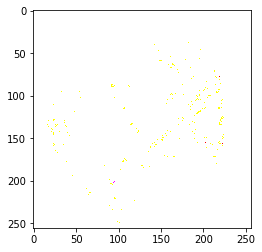

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 / 19
Etiqueta: 1.0


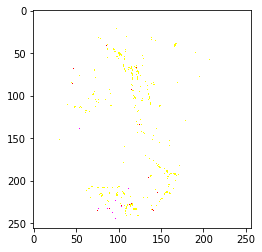

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 / 19
Etiqueta: 0.0


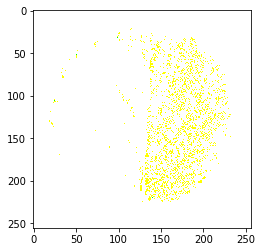

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 / 19
Etiqueta: 0.0


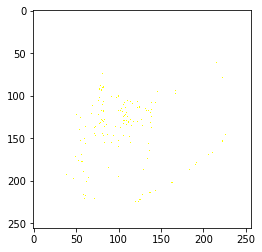

In [11]:
# Modifique la siguiente ruta acorde a su entorno de desarrollo
hdf5_path = 'datasets/data_healthy.h5'
batch_size = 50
batch_n = 4
hdf5_file = read_h5_dataset(hdf5_path, batch_size, batch_n)
hdf5_file.close()

## Bibliografía

[1] http://www.image-net.org

[2] https://www.h5py.org

[3] https://www.tensorflow.org/tutorials/load_data/tf_records

[4] https://plantvillage.psu.edu

[5] https://arxiv.org/abs/1511.08060